In [ ]:
#IMPORTING LIBRARIES

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #prepocessing and augumentation
from tensorflow.keras import Sequential #sequential model container
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #CNN layers
import matplotlib.pyplot as plt #plotting curves
import os #handle file paths
from tensorflow.keras.optimizers import Adam #optimizer

from tensorflow.keras.layers import BatchNormalization #normalizes activation in each layer to stabilize and speed up training
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint #tools to adjust learning and stop training early

In [ ]:
#DOWNLOAD DATASET

dataset_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
dataset_path = tf.keras.utils.get_file(fname='cats_and_dogs_filtered.zip', origin=dataset_url, extract=True) #download dataset and extract files (extract=True)

#DEFINE DATASET DIRECTORIES

#NOTE: path may differ depending on system: works in Google Colab
base_dir = "/root/.keras/datasets/cats_and_dogs_filtered_extracted/cats_and_dogs_filtered" #base path
train_dir = os.path.join(base_dir, "train") #training images
validation_dir = os.path.join(base_dir, "validation") #validation images

print("Dataset extracted to:", base_dir)
print("Train subfolders:", train_dir)
print("Validation subfolders:", validation_dir)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset extracted to: /root/.keras/datasets/cats_and_dogs_filtered_extracted/cats_and_dogs_filtered
Train subfolders: /root/.keras/datasets/cats_and_dogs_filtered_extracted/cats_and_dogs_filtered/train
Validation subfolders: /root/.keras/datasets/cats_and_dogs_filtered_extracted/cats_and_dogs_filtered/validation


In [ ]:
#INSPECT DIRECTORIES

print("Contents of training directory:", os.listdir(train_dir))
print("Contents of validation directory:", os.listdir(validation_dir))

Contents of training directory: ['dogs', 'cats']
Contents of validation directory: ['dogs', 'cats']


In [ ]:
#IMAGE SIZE & BATCH

img_size = (150, 150) #resize images
batch_size = 32 #number of images per batch

#DATA AUGMENTATION (TRAIN)

train_datagen = ImageDataGenerator(
    rescale=1.0/255, #image pixel values normalized [0,1]
    rotation_range=40, #rotate randomly up to ±40°
    width_shift_range=0.2, #move images randomly left/right by 20%
    height_shift_range=0.2, #move images randomly up/down by 20%
    shear_range=0.2, #tilt images
    zoom_range=0.2, #randomly zoom in/out
    horizontal_flip=True, #mirror images
    fill_mode='nearest' #fill missing pixels
)

#PREPROCESSING (VALIDATION SET)

validation_datagen = ImageDataGenerator(rescale=1.0/255) #only normalize

#BUILT DATA GENERATORS

train_generator = train_datagen.flow_from_directory(
    train_dir, #path to training directory
    target_size=img_size, #resizes images to 150x150
    batch_size=batch_size, #groups them into batches
    class_mode='binary', #binary labels (0,1)
    shuffle=True #shuffle for training
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, #path to validation directory
    target_size=img_size, #resizes images to 150x150
    batch_size=batch_size, #groups them into batches
    class_mode='binary', #binary labels (0,1)
    shuffle=False #keep order for validation
)



print("Class indices:", train_generator.class_indices)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}


In [ ]:
#DEFINE MODEL (CNN)

model = Sequential([
    # Convolutional + Pooling blocks
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(), #3D features maps into 1D

    Dense(512, activation='relu'), #combines features

    Dropout(0.5), #drops layers to reduce overfitting

    Dense(1, activation='sigmoid') #output layer (binary classification)
])


#COMPILE MODEL

model.compile(
    optimizer=Adam(learning_rate=0.001), # adjusts learning
    loss='binary_crossentropy', # correct loss for binary classification
    metrics=['accuracy'] # track accuracy during training
)

#MODEL SUMMARY

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,073 (72.61 MB)

 Trainable params: 19,034,625 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#DEFINE CALLBACKS

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1), #reduces learning rate if validation loss stops imrpoving
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),  #stops training if no improvement for 5 epochs, restores best weights


]

In [ ]:
#TRAIN MODEL

history = model.fit(
    train_generator, #training data (with augmentation)
    epochs=30, #number of times to loop over the training set
    validation_data=validation_generator, #validation data (no augmetnation)
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 342ms/step - accuracy: 0.5437 - loss: 7.2144 - val_accuracy: 0.5010 - val_loss: 6.6552 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.6020 - loss: 1.0651 - val_accuracy: 0.5000 - val_loss: 12.2067 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.6036 - loss: 0.6965 - val_accuracy: 0.5000 - val_loss: 2.5565 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.6349 - loss: 0.6666 - val_accuracy: 0.5680 - val_loss: 1.0212 - learning_rate: 0.0010
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.6453 - loss: 0.6545 - val_accuracy: 0.4990 - val_loss: 1.8296 - learning_rate: 0.0010
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.6309 - loss: 0.6379 - val_accuracy: 0.5910 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.6727 - loss: 0

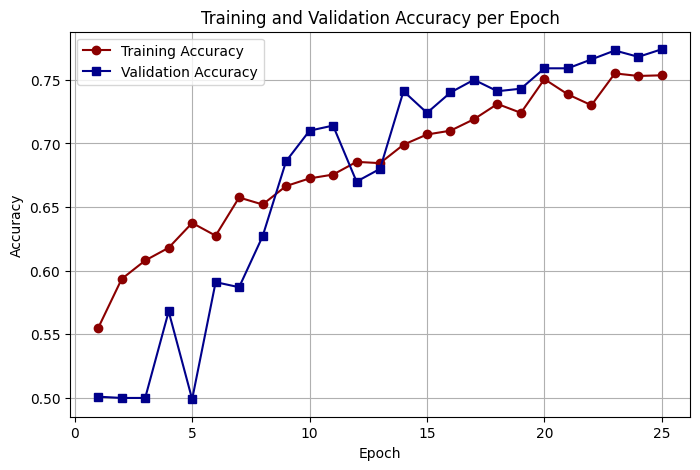

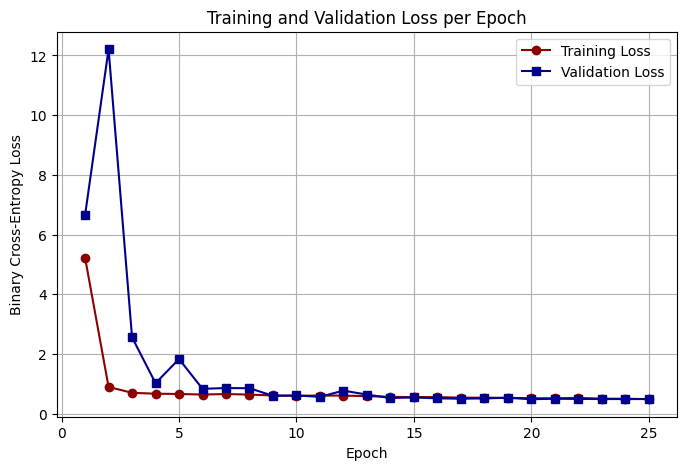

In [ ]:
#PLOT

#EXTRACT HISTORY VALUES

train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
epochs     = range(1, len(train_acc) + 1)

#ACCURACY PLOT

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, 'o-', color='darkred', label='Training Accuracy')
plt.plot(epochs, val_acc, 's-', color='darkblue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

#LOSS PLOT

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, 'o-', color='darkred', label='Training Loss')
plt.plot(epochs, val_loss, 's-', color='darkblue', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True)
plt.legend()
plt.show()
